In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

#### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['foradm_jan18','backrosVS_jan18']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,26)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        else:
            print(name,'missing')
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [5]:
sectransp_2018.keys()

dict_keys(['foradm_jan18', 'backrosVS_jan18'])

### Shifting functions

In [6]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import variable data

In [7]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

# density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
# dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

# density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
# dens_diff_haro = np.array(density_haro.south - density_haro.north)

density_vspr = pd.read_csv('../notebooks/sigma_2017-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides = pd.read_csv('../notebooks/low_pass_tide_2018-22_BP.csv')
# tides = pd.read_csv('low_pass_tide_18-22.csv').iloc[:730,:]


date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens))
print(dens_diff_ros.size)

2191
(2191,)
2191
2191


#### Shifting

In [8]:
admtorosl = sectransp_2018['foradm_jan18'][4]
admtorosbl = sectransp_2018['backrosVS_jan18'][2]

admtoros = pd.Series(admtorosl,index=datelist_vs)
admtorosb = pd.Series(admtorosbl,index=datelist_vs)

In [9]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(admtoros,age_2018['foradm_jan18'][4],datelist_vs,base,factor)
        dfr2 = shift_time(admtorosb,age_2018['backrosVS_jan18'][2],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.775:
            print (base, factor, corr_arr[i, j])
            
i_base,i_factor = np.where(corr_arr==np.max(corr_arr))

base = base_arr[i_base]
factor = factor_arr[i_factor]

print(base,factor)

[-0.9] [0.6]


0.7522975657727826


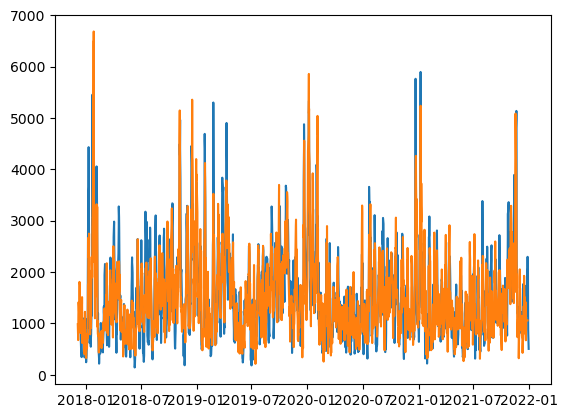

In [10]:
admtoros_sh = shift_time(admtoros,age_2018['foradm_jan18'][4],datelist_vs,base[0],factor[0])
admtorosb_sh = shift_time(admtorosb,age_2018['backrosVS_jan18'][2],datelist_vs,-base[0],-factor[0])

admtoros_m,admtorosb_m,c,admtoros_avg = merge(admtoros_sh,admtorosb_sh)
print(c)

plt.plot(admtoros_m.Transport)
plt.plot(admtorosb_m.Transport)

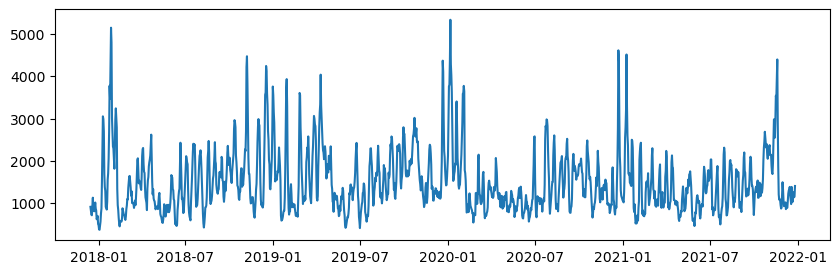

In [11]:
fig,ax = plt.subplots(figsize=(10,3))
plt.plot(admtoros_avg.dropna())

#### Import rostosouth data

In [12]:
rostosouth_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth17-21.csv')
datelist_rostosouth = pd.to_datetime(rostosouth_df['Date'])
rostosouth = pd.DataFrame({'Transport':rostosouth_df['Transport'].values},index=datelist_rostosouth)['Transport'][365:]
datelist_rostosouth = pd.to_datetime(rostosouth.index)

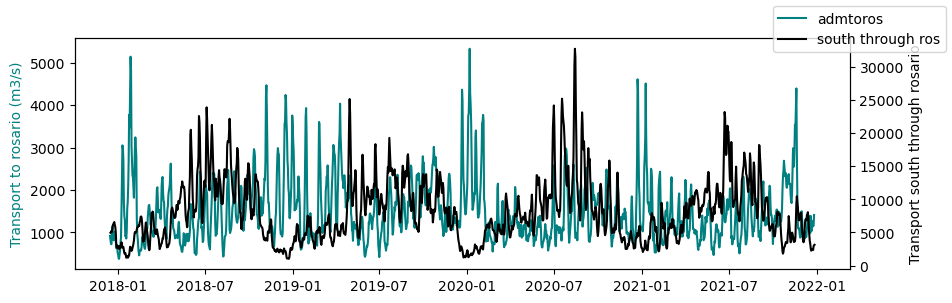

In [13]:
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(admtoros_avg.dropna(),color='teal',label='admtoros')
ax.set_ylabel('Transport to rosario (m3/s)',color='teal')
ax2 = ax.twinx()
ax2.plot(rostosouth.dropna(),color='k',label='south through ros')
ax2.set_ylabel('Transport south through rosario')
fig.legend()

Quantaties don't really match ... transport to rosario highest is 5000, this decrease doesn't correspond to the 10000 increase in south transport ... although a lot of the increase in south flow is because of increased FR SO this could still be why higher proportion through rosario.

### Import data of freshwater in puget sound

In [14]:
#Import puget river data
pugetr_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/puget_rivers_avg.csv')
datelist_pugetr = pd.to_datetime(pugetr_df['Date'])
pugetr = pd.DataFrame({'discharge(kg/m2/s)':pugetr_df['0'].values},index=datelist_pugetr)['discharge(kg/m2/s)'].rolling(window=4,center=True).mean().dropna()
datelist_pugetr = pd.to_datetime(pugetr.index)

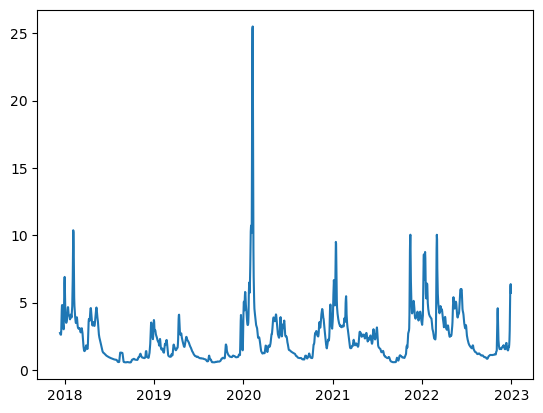

In [15]:
plt.plot(pugetr)

### Correlations with freshwater from puget

-0.478460464726351


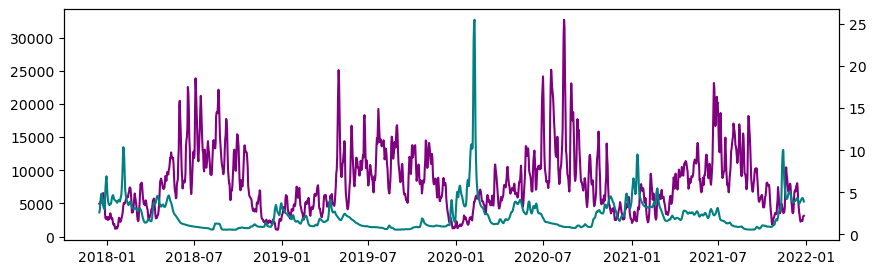

In [16]:
mask = np.isin(datelist_pugetr,datelist_rostosouth)
pugetr_ros = pugetr[mask]
mask = np.isin(datelist_rostosouth,datelist_pugetr)
rostosouth_18 = rostosouth[mask]

corr,p = stats.spearmanr(rostosouth_18,pugetr_ros)
print(corr)

fig,ax = plt.subplots(figsize=(10,3))
ax.plot(rostosouth_18,color='purple')
ax2 = ax.twinx()
ax2.plot(pugetr_ros,color='teal')

Look at correlation b/w puget rivers and Fraser River

#### Import Fraser River data

In [17]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge.csv')
datelist_FR = pd.to_datetime(FR_data['Date'])
FR_4mean = pd.DataFrame({'Discharge (m3/s)':FR_data['Discharge (m3/s)'].values},index=datelist_FR)['Discharge (m3/s)'].rolling(window=4,center=True).mean().dropna()
datelist_FR = pd.to_datetime(FR_4mean.index)

#### Import Haro to south

In [18]:
harotosouth_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/harotosouth18-21.csv')
datelist_harotosouth = pd.to_datetime(harotosouth_df['Date'])
harotosouth = pd.DataFrame({'Transport':harotosouth_df['Transport'].values},index=datelist_harotosouth)['Transport']
datelist_harotosouth = pd.to_datetime(harotosouth.index)

Correlation (puget rivers and south Haro flow): -0.48357645955078604
Correlation (FR and south Haro flow): 0.45278575373411317


Text(0.5, 1.0, 'Haro')

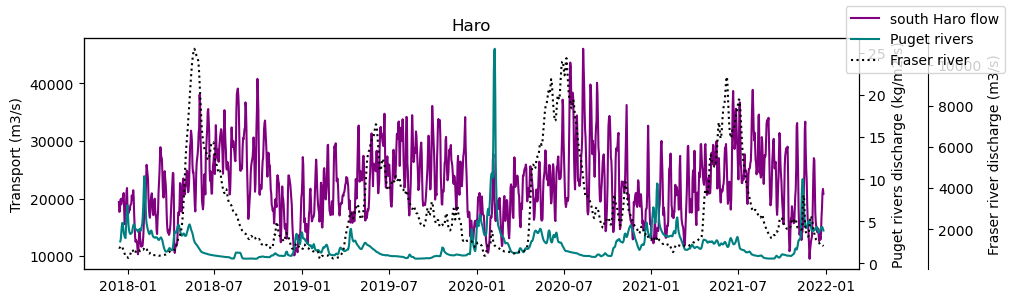

In [19]:
mask = np.isin(datelist_pugetr,datelist_harotosouth)
pugetr_haro = pugetr[mask]
mask = np.isin(datelist_harotosouth,datelist_pugetr)
harotosouth_18 = harotosouth[mask]

corr,p = stats.spearmanr(pugetr_haro,harotosouth_18)
print(f'Correlation (puget rivers and south Haro flow): {corr}')

mask = np.isin(datelist_FR,datelist_harotosouth)
FR_haro = FR_4mean[mask]
# mask = np.isin(datelist_harotosouth,datelist_FR)
# harotosouth_18 = harotosouth[mask]

corr,p = stats.spearmanr(FR_haro,harotosouth_18)
print(f'Correlation (FR and south Haro flow): {corr}')

fig,ax = plt.subplots(figsize=(10,3))

ax.plot(harotosouth,color='purple',label='south Haro flow')
ax2 = ax.twinx()
ax2.plot(pugetr_ros,color='teal',label='Puget rivers')
ax3=ax.twinx()
ax3.plot(FR_haro,color='k',ls=':',label='Fraser river')
ax3.spines['right'].set_position(('outward',50))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Puget rivers discharge (kg/m2/s)')
ax3.set_ylabel('Fraser river discharge (m3/s)')
fig.legend()
ax.set_title('Haro')


Correlation (b/w puget rivers and south rosario flow): -0.478460464726351
Correlation (b/w FR and south rosario flow): 0.6257612478919586
Correlation (b/w Fraser river and Puget rivers): -0.1559147168338718


Text(0.5, 1.0, 'Rosario')

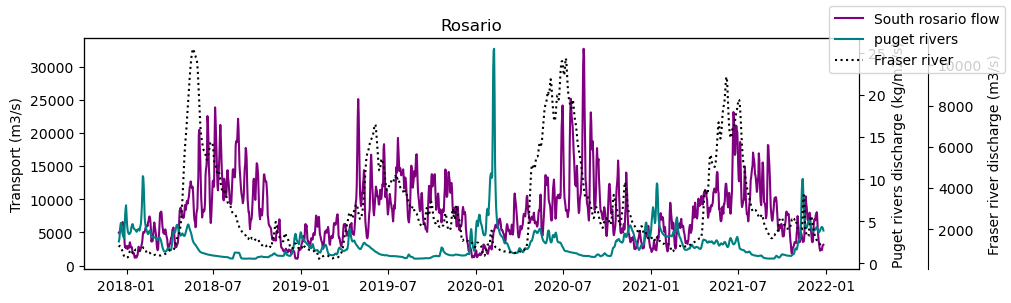

In [20]:
mask = np.isin(datelist_pugetr,datelist_rostosouth)
pugetr_ros = pugetr[mask]
mask = np.isin(datelist_rostosouth,datelist_pugetr)
rostosouth_18 = rostosouth[mask]

corr,p = stats.spearmanr(rostosouth_18,pugetr_ros)
print('Correlation (b/w puget rivers and south rosario flow):',corr)

mask = np.isin(datelist_rostosouth,datelist_FR)
rostosouth_FR = rostosouth[mask]
mask = np.isin(datelist_FR,datelist_rostosouth)
FR_ros = FR_4mean[mask]

corr,p = stats.spearmanr(rostosouth_FR,FR_ros)
print('Correlation (b/w FR and south rosario flow):',corr)

mask = np.isin(datelist_FR,datelist_pugetr)
FR_p = FR_4mean[mask]
mask = np.isin(datelist_pugetr,datelist_FR)
pugetr_FR = pugetr[mask]

corr,p = stats.spearmanr(pugetr_FR.dropna(),FR_p)
print('Correlation (b/w Fraser river and Puget rivers):',corr)

fig,ax = plt.subplots(figsize=(10,3))

ax.plot(rostosouth_18,color='purple',label='South rosario flow')

ax2 = ax.twinx()
ax2.plot(pugetr_ros,color='teal',label='puget rivers')

ax3 = ax.twinx()
ax3.plot(FR_ros,color='k',label='Fraser river',ls=':')
ax3.spines['right'].set_position(('outward',50))

ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Puget rivers discharge (kg/m2/s)')
ax3.set_ylabel('Fraser river discharge (m3/s)')
fig.legend()
ax.set_title('Rosario')

### Import density difference data

In [21]:
density_admros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admros.csv')
dens_diff_admros = density_admros.south - density_admros.north

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
print(len(dens_diff_admros))
print(len(datelist_dens))

dens_diff_admros.index = datelist_dens

datelist_dens = dens_diff_admros.index

2557
2557


In [22]:
mask = np.isin(datelist_dens,datelist_rostosouth)
densdiff_admros = dens_diff_admros[mask]

corr,p = stats.spearmanr(densdiff_admros,rostosouth)
print(corr)

-0.6470065689520087


In [23]:
corr,p = stats.spearmanr(FR_ros,densdiff_admros)
print(corr)

-0.4141961245720354


In [24]:
mask = np.isin(datelist_dens,datelist_harotosouth)
densdiff_haro = dens_diff_admros[mask]

stats.spearmanr(densdiff_haro,harotosouth)

SignificanceResult(statistic=-0.4005071488420724, pvalue=5.656961679571756e-58)

### Import rosario N/S density data

In [25]:
density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_ros = density_ros.south - density_ros.north
dens_diff_ros.index = datelist_dens

In [26]:
corr,p = stats.spearmanr(dens_diff_admros,dens_diff_ros)
print(corr)

-0.567511098067297


In [27]:
mask = np.isin(datelist_dens,datelist_rostosouth)
densdiff_ros = dens_diff_ros[mask]

corr,p = stats.spearmanr(densdiff_ros,rostosouth)
print(corr)

0.8052837219739994


In [28]:
mask = np.isin(datelist_pugetr,datelist_harotosouth)
pugetr_haro = pugetr[mask]

stats.spearmanr(pugetr_haro,harotosouth)

SignificanceResult(statistic=-0.48357645955078604, pvalue=2.3608017044185223e-87)

#### Import adm/pr density data

In [29]:
density_admpr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admpr.csv')
dens_diff_admpr = density_admpr.south - density_admpr.north

dens_diff_admpr.index = datelist_dens

rostosouth

In [30]:
mask = np.isin(datelist_dens,datelist_rostosouth)
densdiff_admpr_ros= dens_diff_admpr[mask]

corr,p = stats.spearmanr(densdiff_admpr_ros,rostosouth)
print(corr)

-0.7653644982584882


Text(0.5, 1.0, 'Rosario')

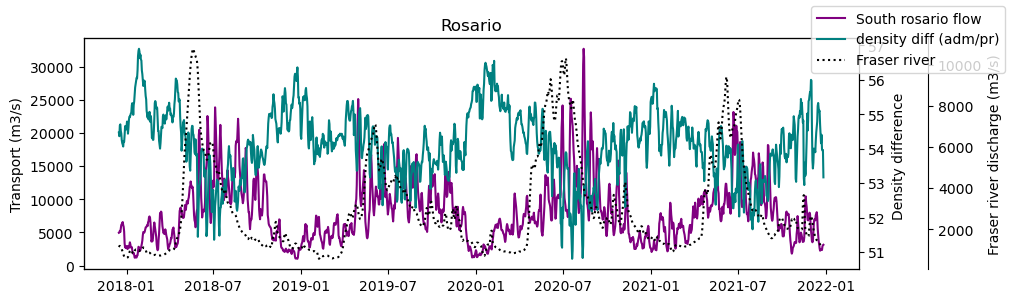

In [31]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(rostosouth_18,color='purple',label='South rosario flow')

ax2 = ax.twinx()
ax2.plot(densdiff_admpr_ros,color='teal',label='density diff (adm/pr)')

ax3 = ax.twinx()
ax3.plot(FR_ros,color='k',label='Fraser river',ls=':')
ax3.spines['right'].set_position(('outward',50))

ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference ')
ax3.set_ylabel('Fraser river discharge (m3/s)')
fig.legend()
ax.set_title('Rosario')

harotosouth

In [32]:
mask = np.isin(datelist_dens,datelist_harotosouth)
densdiff_admpr_haro= dens_diff_admpr[mask]

corr,p = stats.spearmanr(densdiff_admpr_haro,harotosouth)
print(corr)

-0.7460046168390262


Density difference: pr - adm

In [33]:
corr,p = stats.spearmanr(FR_ros,densdiff_admpr_ros)
print('Correlation b/w dens diff and FR:',corr)
corr,p = stats.spearmanr(pugetr_ros,densdiff_admpr_ros)
print('Correlation b/w dens diff and puget rivers:',corr)

Correlation b/w dens diff and FR: -0.5373998647531677
Correlation b/w dens diff and puget rivers: 0.5581023057234216


Density difference: ros-adm

In [34]:
corr,p = stats.spearmanr(pugetr_ros,densdiff_admros)
print('Correlation b/w dens diff and puget rivers:',corr)
corr,p = stats.spearmanr(FR_ros,densdiff_admros)
print('Correlation b/w dens diff and FR:',corr)


Correlation b/w dens diff and puget rivers: 0.42483077796658664
Correlation b/w dens diff and FR: -0.4141961245720354


Text(0.5, 1.0, 'Rosario')

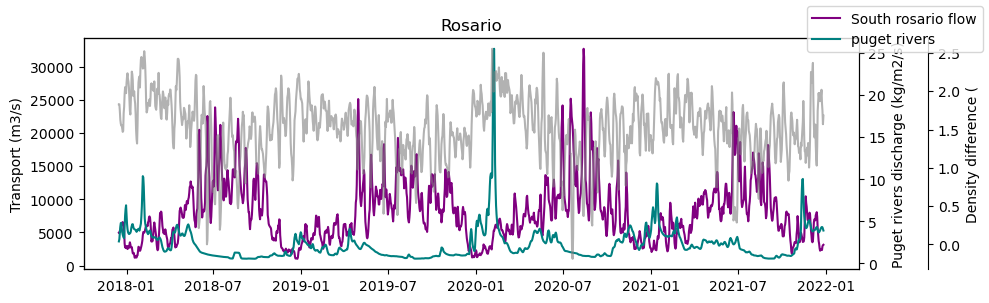

In [35]:
fig,ax = plt.subplots(figsize=(10,3))

ax.plot(rostosouth_18,color='purple',label='South rosario flow')

ax2 = ax.twinx()
ax2.plot(pugetr_ros,color='teal',label='puget rivers')

ax3 = ax.twinx()
# ax3.plot(densdiff_admpr_ros,color='k',label='Fraser river',ls=':')
ax3.spines['right'].set_position(('outward',50))
ax3.plot(densdiff_admros,color='grey',alpha=0.6)

ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Puget rivers discharge (kg/m2/s)')
ax3.set_ylabel('Density difference (')
fig.legend()
ax.set_title('Rosario')

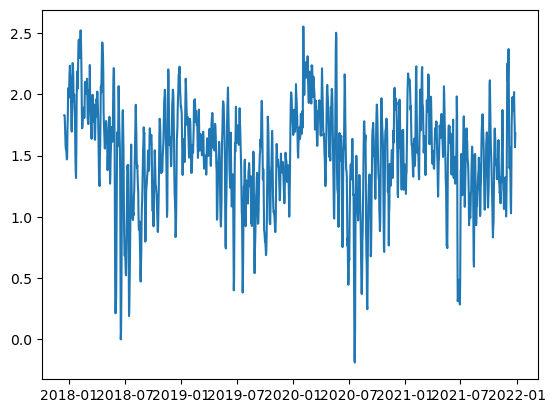

In [36]:
plt.plot(densdiff_admros)